In [1]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 120         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 1

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6
compute_val_at = 0
acc_filtered_r = 0.8

In [2]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
#from keras.models import Sequential
#from keras.layers.core import Dense, Dropout, Activation
#from keras.layers.recurrent import LSTM
#from keras.models import load_model
#import keras
import pandas as pd ## can be remove once pandas_datareader 0.7 using
pd.core.common.is_list_like = pd.api.types.is_list_like ## can be remove once pandas_datareader 0.7 using
import pandas_datareader.data as web
import h5py
import os
#from keras import backend as K

In [3]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )
    #TODO Use previous close instead of open
    df['change'] = df['close'] - df['open']
    for i, row in df.iterrows():
        df.at[i, 'high'] = df.at[i, 'high'] - (df.at[i, 'open'] if df.at[i, 'open'] > df.at[i, 'close'] else df.at[i, 'close'])
        df.at[i, 'low'] = (df.at[i, 'close'] if df.at[i, 'close'] < df.at[i, 'open'] else df.at[i, 'open']) - df.at[i, 'low']
    df.dropna(inplace=True)
    df = df.drop('open', axis=1)
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        #df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        #df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [4]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [5]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(df['high'], color='red', label='high')
    ax1.legend(loc='best')
 
    ax2.plot(df['low'], color='red', label='low')
    ax2.legend(loc='best')
    plt.show()

             high           low     close    change      50ma     100ma  \
199  4.445337e-14  6.182380e-03  0.357085 -0.000150  0.351429  0.351070   
200  2.002002e-03  1.545595e-02  0.356606 -0.000060  0.351433  0.351063   
201  1.301301e-02  7.727975e-03  0.356893  0.000035  0.351445  0.351060   
202  4.445337e-14  1.545595e-03  0.357133  0.000015  0.351502  0.351082   
203  6.006006e-03  6.863821e-14  0.358138  0.000095  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


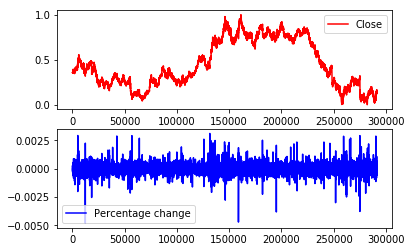

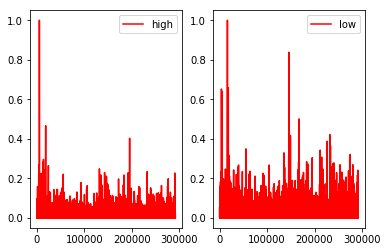

In [6]:
plot_stock(df)

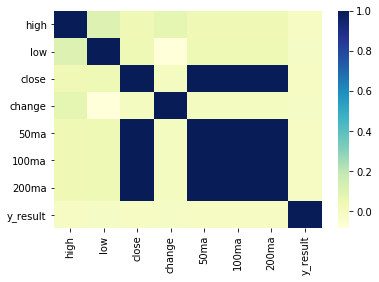

In [7]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [8]:
_stack_itdef load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [9]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 7


c:\users\lai\anaconda3\envs\j6stock\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Amount of training data = 261918.9
Amount of testing data = 29102.100000000002
(174613, 120, 7) (174613,) (70626, 120, 7) (70626,)
7


In [10]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [11]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')
    acc_filtered_r_ = tf.placeholder(tf.float32, name = 'acc_filtered_r')

Construct inputs to LSTM

In [12]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [13]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
 
    # Accuracy on >80%  
    np_logits_b = tf.reduce_max(logits, axis=1) >= acc_filtered_r_
    np_logits_b.set_shape([None])
    labels_filtered = tf.boolean_mask(labels_, np_logits_b)
    logits_filtered = tf.boolean_mask(logits, np_logits_b)
    
    correct_pred_filtered = tf.equal(tf.argmax(logits_filtered, 1), tf.argmax(labels_filtered, 1))
    accuracy_filtered = tf.reduce_mean(tf.cast(correct_pred_filtered, tf.float32), name='accuracy_filtered')
    
    tf.summary.scalar('logits', tf.shape(logits)[0])
    tf.summary.scalar('logits_filtered', tf.shape(logits_filtered)[0])

    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [14]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [15]:
interation_compute_val = 40
validation_acc = []
validation_acc_filtered = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "KLSE-QUANT:4321")
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "checkpoints/har-lstm.ckpt")
    iteration = 1
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        summ_writer = tf.summary.FileWriter('tensorboardlog',
                                      sess.graph)
        merged = tf.summary.merge_all()
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate, 
                    acc_filtered_r_ : acc_filtered_r}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == compute_val_at):
                

                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_acc_filtered_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state,
                           acc_filtered_r_ : acc_filtered_r}
                    
                    # Loss
                    summary, loss_v, state_v, acc_v, acc_filtered_v = sess.run([merged, cost, final_state, accuracy, accuracy_filtered], feed_dict = feed)
                    summ_writer.add_summary(summary, iteration)
                    val_acc_.append(acc_v)
                    val_acc_filtered_.append(acc_filtered_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)),
                      "Validation acc filtered: {:.6f}".format(np.mean(val_acc_filtered_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_acc_filtered.append(np.mean(val_acc_filtered_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Epoch: 0/1 Iteration: 5 Train loss: 0.426510 Train acc: 0.847168
Epoch: 0/1 Iteration: 10 Train loss: 0.342419 Train acc: 0.886719
Epoch: 0/1 Iteration: 15 Train loss: 0.325711 Train acc: 0.884277
Epoch: 0/1 Iteration: 20 Train loss: 0.343015 Train acc: 0.888184
Epoch: 0/1 Iteration: 25 Train loss: 0.369937 Train acc: 0.861328
Epoch: 0/1 Iteration: 30 Train loss: 0.265900 Train acc: 0.909180
Epoch: 0/1 Iteration: 35 Train loss: 0.211090 Train acc: 0.921875
Epoch: 0/1 Iteration: 40 Train loss: 0.277207 Train acc: 0.894043
Epoch: 0/1 Iteration: 40 Validation loss: 2.180513 Validation acc: 0.407945 Validation acc filtered: 0.408003
Epoch: 0/1 Iteration: 45 Train loss: 0.229635 Train acc: 0.928223
Epoch: 0/1 Iteration: 50 Train loss: 0.239953 Train acc: 0.911133
Epoch: 0/1 Iteration: 55 Train loss: 0.327888 Train acc: 0.871094
Epoch: 0/1 Iteration: 60 Train loss: 0.336471 Train acc: 0.892578
Epoch: 0/1 Iteration: 65 Train 

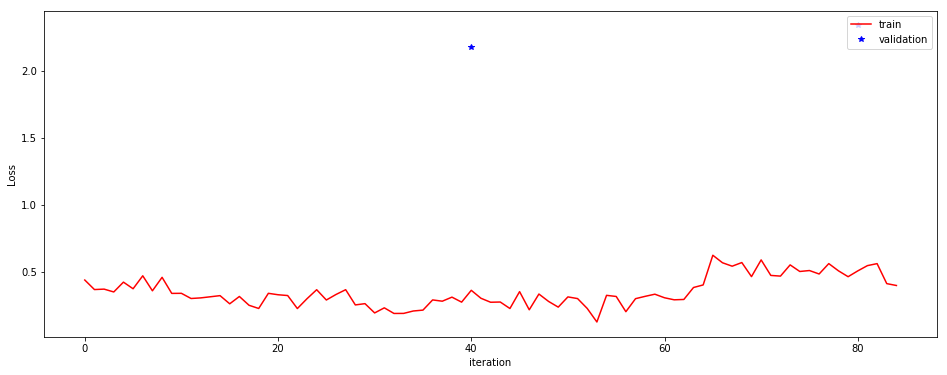

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)
tt = t[t % interation_compute_val == compute_val_at]
tt = tt[1:]
plt.figure(figsize = (16,6))
plt.plot(t, np.array(train_loss), 'r-', tt, np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

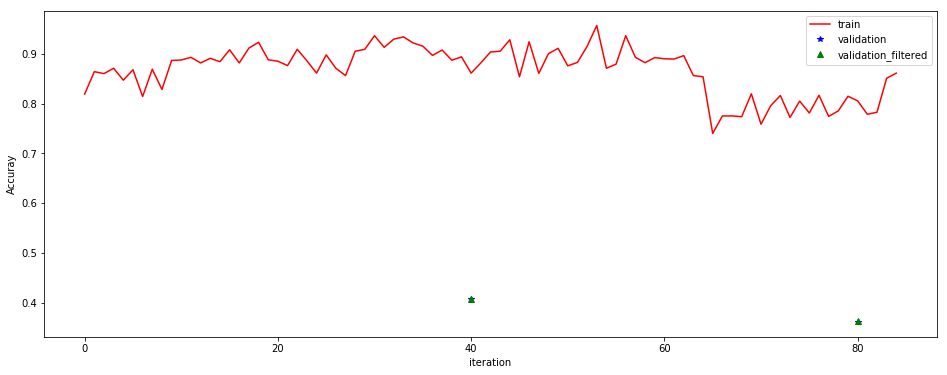

In [17]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (16,6))

plt.plot(t, np.array(train_acc), 'r-', tt, validation_acc, 'b*', tt, validation_acc_filtered, 'g^')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation', 'validation_filtered'], loc='upper right')
plt.show()

Evaluate on test set

In [18]:
test_acc = []
test_acc_filtered = []
with tf.Session(graph=graph) as sess:
    # Restore
    sess.run(tf.local_variables_initializer())
    saver = tf.train.import_meta_graph('checkpoints\har-lstm.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))

    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)        
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size): 
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state,
                acc_filtered_r_ : acc_filtered_r}
        
        batch_acc,batch_acc_filtered, test_state = sess.run([ accuracy,accuracy_filtered,final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        test_acc_filtered.append(batch_acc_filtered)
        print("Each accuracy: {:.6f}. {:.6f}".format(batch_acc, batch_acc_filtered))       
    print("Total Test accuracy: {:.6f}. Filtered: {:.6f}".format(np.mean(test_acc),np.mean(test_acc_filtered)))


INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70626, 3)
Each accuracy: 0.434082. 0.446103
Each accuracy: 0.387695. 0.383815
Each accuracy: 0.397461. 0.390831
Each accuracy: 0.390137. 0.396298
Each accuracy: 0.429688. 0.430881
Each accuracy: 0.493164. 0.495306
Each accuracy: 0.421875. 0.433260
Each accuracy: 0.486816. 0.495098
Each accuracy: 0.540039. 0.538504
Each accuracy: 0.426270. 0.429010
Each accuracy: 0.381348. 0.383903
Each accuracy: 0.533203. 0.535995
Each accuracy: 0.446777. 0.454702
Each accuracy: 0.497559. 0.517687
Each accuracy: 0.331055. 0.330460
Each accuracy: 0.326660. 0.330235
Each accuracy: 0.310059. 0.310364
Each accuracy: 0.328613. 0.318157
Each accuracy: 0.193848. 0.184632
Each accuracy: 0.287598. 0.287975
Each accuracy: 0.243652. 0.239546
Each accuracy: 0.320312. 0.313402
Each accuracy: 0.357422. 0.348428
Each accuracy: 0.305176. 0.304619
Each accuracy: 0.308594. 0.305882
Each accuracy: 0.314453. 0.302717
Each accuracy: 0.287109. 0.283079
Eac

In [19]:
import datetime
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


SyntaxError: invalid syntax (<ipython-input-19-e92351da6cd6>, line 2)

In [ ]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print(len(logits.get_shape().as_list()))
print(len(np_logits_b.get_shape().as_list()))
print (a[a[:,2]!=0])

In [ ]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

In [ ]:
print(50%1)

In [ ]:
print(tf.shape(np_logits_b))
print(type(np_logits_b))
print(np_logits_b)

In [ ]:
print(tf.__version__)